In [1]:
using CircularArrays,Plots

# 1. Clean Implementation (Slow)

In [9]:
struct Code
    len::Int
    state::CircularArray{UInt8,2}
    future::CircularArray{UInt8,2}
end

function Code(l,v)
    if v==0
       return Code(l,CircularArray{UInt8,2}(zeros(UInt8,l,l)),CircularArray(zeros(UInt8,l,l)))
    else
        return Code(l,CircularArray{UInt8,2}(ones(UInt8,l,l)),CircularArray(zeros(UInt8,l,l)))
    end
end
"""
    toomRule!(c::Code)

write c.future according to toom's rule and c.state
"""
function toomRule!(c::Code)
    for i in axes(c.state,1)
        for j in axes(c.state,2)
            if c.state[i,j]+c.state[i+1,j]+c.state[i,j+1] >= 2 
                c.future[i,j]=1
            else
                c.future[i,j]=0
           end
        end
    end
end

"""
    noise!(c::Code,p,q)

apply the noise to c.future and write the result in c.state 
"""
function noise!(c::Code,p,q)
    for i in axes(c.state,1)
        for j in axes(c.state,2)
            if c.future[i,j]==1 && rand()<q
                c.state[i,j]=0
            elseif c.future[i,j]==0 && rand()<p
                c.state[i,j]=1
            else
                c.state[i,j]=c.future[i,j]
            end
        end
    end
end

"""
    logical(c::Code)

return the logical value stored in c
"""
function logical(c::Code)
    if sum(c.state)>c.len*c.len/2
        return 1
    else
        return 0
    end
end



Code

In [12]:
function main()
    avgNum=100

    ls=[2,4,8,16]
    ps=collect(0:0.02:.5)


    data=Array{Any}(undef,length(ls),length(ps))


    for i_l in eachindex(ls)
        l=ls[i_l]
        T=5*l
        println("\nl:$l")
        for i_p in eachindex(ps)
            p=ps[i_p]
            print("p:$p| ")
            k=0
            for r in 1:avgNum
                
                c=Code(l,0)
                for t in 1:T
                    toomRule!(c)
                    noise!(c,p,p)

                end
                k+=logical(c)
            end
            data[i_l,i_p]=k/avgNum
        end
    end

end

main()


l:2
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:16
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 

# 2. Simple Implementation (Fast)

In [2]:
"""
    toomRule(code::CircularArray,r)

return the propsed future state of the site r=i,j according to the toom's rule
"""
function toomRule(code::CircularArray,r)
    i,j=r
    
    if code[i,j]+code[i+1,j]+code[i,j+1] >= 2 
        return 1
    else
        return 0
   end
end

"""
    localMajRule(code::CircularArray,r)

return the propsed future state of the site r=i,j according to the local majority rule
"""
function localMajRule(code::CircularArray,r)
    i,j=r
    
    if code[i,j]+code[i+1,j]+code[i,j+1]+code[i-1,j]+code[i,j-1] >= 3 
        return 1
    else
        return 0
   end
end

"""
    evolve(code::CircularArray,rule,p,q)

one step evolution of the lattice code according to rule followed by noise with parameters p and q
"""
function evolve(code::CircularArray{UInt8,2},rule,p,q)
    l=size(code,1)
    futureCode=CircularArray(zeros(UInt8,l,l))
    for i in axes(code,1)
        for j in axes(code,2)
            futureCode[i,j]=rule(code,(i,j))
            if futureCode[i,j]==1 && rand()<q
                futureCode[i,j]=0
            elseif futureCode[i,j]==0 && rand()<p
                futureCode[i,j]=1
            end
        end
    end
    return futureCode
end


"""
    logical(c::Code)

return the logical value stored in c
"""
function logical(code::CircularArray{UInt8,2})
    if sum(code)>size(code,1)^2/2
        return 1
    else
        return 0
    end
end

logical

## 2.1 Toom's rule Threshold

In [19]:
avgNum=1000

ls=[2,4,8,16]
ps=collect(0:0.02:.5)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=5*l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        k=0
        for r in 1:avgNum
            code=CircularArray(zeros(UInt8,l,l))
            for t in 1:T
                code=evolve(code,toomRule,p,p)
            end
            k+=logical(code)
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:2
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:16
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 

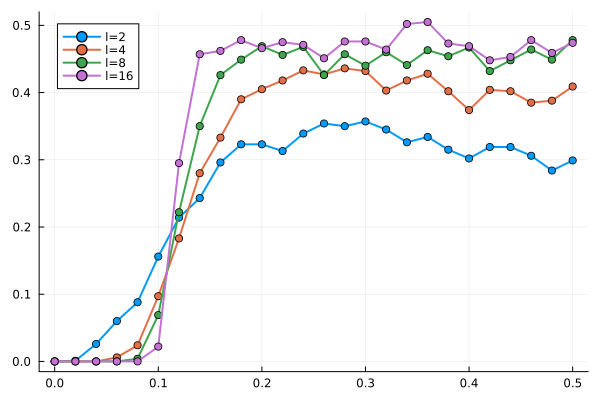

In [20]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

## 2.2. Noise density 

In [25]:
avgNum=100

ls=[2,4,8,16]
ps=collect(0:0.02:.5)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=5*l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        
        k=0
        magnetization=zeros(Float64,T)

        for r in 1:avgNum
            code=CircularArray(zeros(UInt8,l,l))
            for t in 1:T
                code=evolve(code,toomRule,p,p)
                magnetization[t]+=sum(code)/l^2
            end
            k+=logical(code)
        end
        data[i_l,i_p]=[k/avgNum,magnetization./avgNum]
    end
end




l:2
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:16
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 

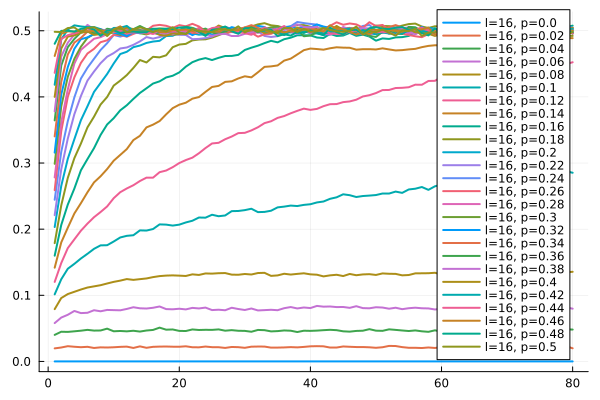

In [29]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    if l!=16 continue end
    Ys=[]
    for i_p in eachindex(ps)
        p=ps[i_p]
        push!(Ys, )
        plot!(plt,data[i_l,i_p][2],label="l=$l, p=$p",lw=2)

    end
end
display(plt)

## 2.3 local majority threshold

In [31]:
avgNum=1000

ls=[2,4,8,16]
ps=collect(0:0.02:.5)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=5*l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        k=0
        for r in 1:avgNum
            code=CircularArray(zeros(UInt8,l,l))
            for t in 1:T
                code=evolve(code,localMajRule,p,p)
            end
            k+=logical(code)
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:2
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:16
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 

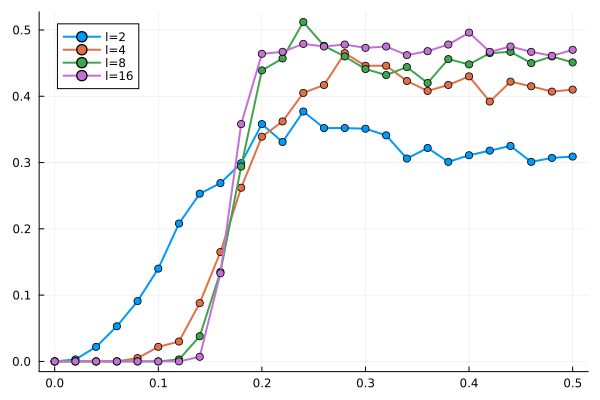

In [32]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

# 3. Quantum Repeatition Code
In this section we consider the quantum repeatition code. The difference is that the noise model is just application of bit-flip unitary (which cannot be biased) with probability p. Also here we inlcude measurement error with probability q.

In [2]:
"""
    evolveQ(eState::CircularArray,decdr,p,q)

evolve the state of errors eState by one time step, using local decoder decdr, physical error
probability p and measurement error probability q

# Arguments: 
- 'decdr': a function that takes mu=(mu_N,mu_W,mu_S,mu_E) syndromes and returns 1 (do nothing) or -1 (flip the qubit at the center)

"""
function evolveQ(eState::CircularArray{Int8,2},decdr,p,q)
    l=size(eState,1)
    synds=syndromes(eState,q)
    for i in axes(eState,1)
        for j in axes(eState,2)
            mus=(synds[i,j,1],synds[i-1,j,2],synds[i,j-1,1],synds[i,j,2])
            eState[i,j]*=decdr(mus)*(rand()<p ? -1 : 1)
        end
    end
    return eState
end

"""
    syndromes(eState::CircularArray{UInt8,2}, q::Float64)

return syndromes associated with error state eState with measurement error propbability q.
output is an lxlx2 array synds, where sinds[i,j,:]=[mu_N(i,j),mu_E(i,j)]
"""
function syndromes(eState::CircularArray{Int8,2}, q::Float64)
    synds=CircularArray(zeros(Int8,axes(eState,1),axes(eState,2),2))
    for i in axes(eState,1)
        for j in axes(eState,2)
            mu_N=eState[i,j]*eState[i,j+1]
            mu_E=eState[i,j]*eState[i+1,j]

            synds[i,j,:]=map(x-> rand()<q ? -x : x, [mu_N,mu_E])
        end
    end

    return synds
end

"""
    localMajDecdrQ(mus)

local majority vote decoder, which flips the qubit if there are more than 2 domainwalls around it. 
"""
function localMajDecdrQ(mus)
    return sum(mus)<0 ? -1 : 1
end


"""
    toomsDecdrQ(mus)

tooms rule decoder, which flips the qubit if there are domain walls on the north and the east of the cell. 
"""
function toomsDecdrQ(mus)
    return (mus[1]==-1 && mus[4]==-1 ? -1 : 1)
end

toomsDecdrQ

## 3.1 local majority vote decoder

In [13]:
avgNum=1000

ls=[4,8,16]
ps=collect(0:0.02:.5)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=5*l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        k=0
        for r in 1:avgNum
            eState=CircularArray(ones(Int8,l,l))
            for t in 1:T
                eState=evolveQ(eState,localMajDecdrQ,p,0.0)
            end
            k+= (sum(eState)>0 ? 1 : 0)
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:16
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 

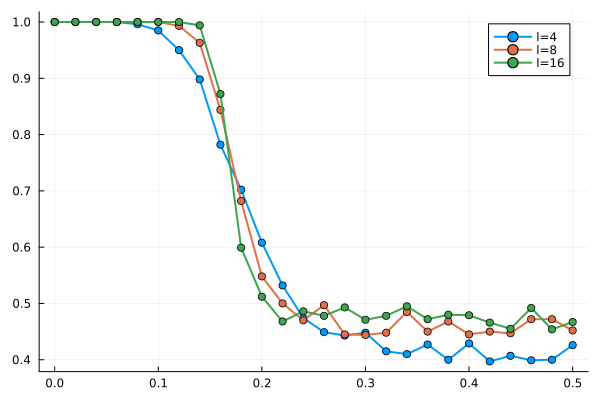

In [14]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

### 3.1.1 with measurement error q=p

In [27]:
avgNum=10000

ls=[4,8,16]
ps=collect(0.11:0.005:0.13)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=2l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        k=0
        for r in 1:avgNum
            eState=CircularArray(ones(Int8,l,l))
            for t in 1:T
                eState=evolveQ(eState,localMajDecdrQ,p,p)
            end
            k+= (sum(eState)>0 ? 1 : 0)
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:4
p:0.11| p:0.115| p:0.12| p:0.125| p:0.13| 
l:8
p:0.11| p:0.115| p:0.12| p:0.125| p:0.13| 
l:16
p:0.11| p:0.115| p:0.12| p:0.125| p:0.13| 

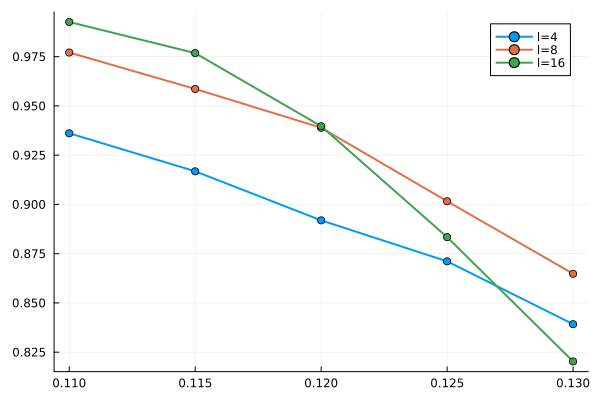

In [28]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

## 3.2 Toom's rule

In [38]:
avgNum=1000

ls=[4,8,16]
ps=collect(0:0.02:.5)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=2l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        k=0
        for r in 1:avgNum
            eState=CircularArray(ones(Int8,l,l))
            for t in 1:T
                eState=evolveQ(eState,toomsDecdrQ,p,0.0)
            end
            k+= (sum(eState)>0 ? 1 : 0)
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:16
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 

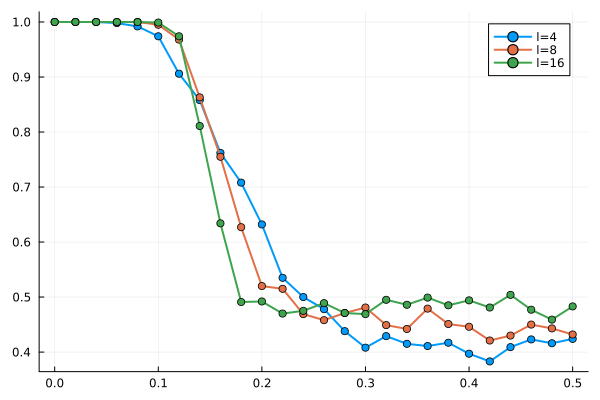

In [39]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

In [40]:
avgNum=1000

ls=[4,8,16]
ps=collect(0:0.02:.5)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=2l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        k=0
        for r in 1:avgNum
            eState=CircularArray(ones(Int8,l,l))
            for t in 1:T
                eState=evolveQ(eState,toomsDecdrQ,p,p)
            end
            k+= (sum(eState)>0 ? 1 : 0)
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:16
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 

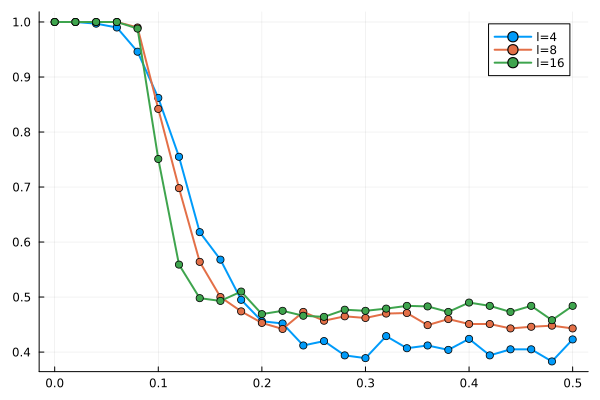

In [41]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

## 3.3 maximum likelyhood decoder

In [5]:
function errorDicts(p)
    cleanCenter=Dict{NTuple{4,Int8},Float64}()
    for mu_N in [1,-1], mu_W in [1,-1], mu_S in [1,-1], mu_E in [1,-1]
        k=(mu_N,mu_W,mu_S,mu_E)
        s=sum(k)
        cleanCenter[k]=(1-p)^(2+s/2)*p^(2-s/2)*(1-p)
    end

    noisyCenter=Dict{NTuple{4,Int8},Float64}()
    for mu_N in [1,-1], mu_W in [1,-1], mu_S in [1,-1], mu_E in [1,-1]
        k=(mu_N,mu_W,mu_S,mu_E)
        s=sum(k)
        noisyCenter[k]=(1-p)^(2-s/2)*p^(2+s/2)*p
    end

    return cleanCenter,noisyCenter
end


function maxLikeDecdrQ(mus,cleanCenter,noisyCenter,q)
    p0=likelyhood(mus,cleanCenter,q)
    p1=likelyhood(mus,noisyCenter,q)
    return p0>p1 ? 1 : -1
end

function diffCount(mus,nus)
    d=0
    for i in eachindex(mus)
        d+= mus[i]==nus[i] ? 0 : 1
    end
    return d
end

function likelyhood(mus, dict, q)
    p=0
    for nus in keys(dict)
        m=diffCount(mus,nus)
        p+=dict[nus]* q^m * (1-q)^(4-m)
    end
    return p
end

likelyhood (generic function with 1 method)

In [6]:
avgNum=1000

ls=[4,8,16]
ps=collect(0.0:0.02:0.5)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=2l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        q=p
        print("p:$p| ")
        cleanCenter,noisyCenter=errorDicts(p)
        mlDecdrQ(mus)=maxLikeDecdrQ(mus,cleanCenter,noisyCenter,q)
        k=0
        for r in 1:avgNum
            eState=CircularArray(ones(Int8,l,l))
            for t in 1:T
                eState=evolveQ(eState,mlDecdrQ,p,q)
            end
            k+= (sum(eState)>0 ? 1 : 0)
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| 

InterruptException: InterruptException:

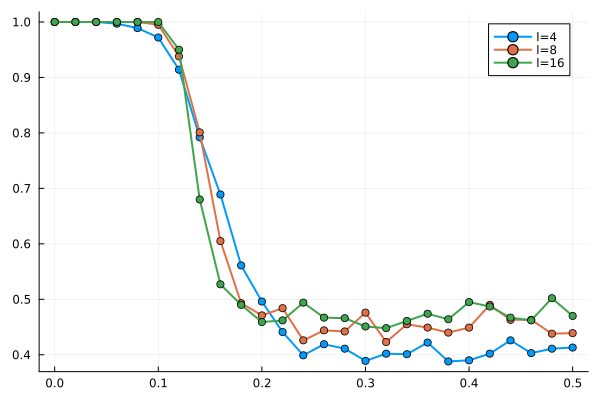

In [44]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

### 3.3.1 max likelyhood decoder with dynamic priors

In [3]:
function initErrorDicts()
    cleanCenter=Dict{NTuple{4,Int8},Float64}()
    noisyCenter=Dict{NTuple{4,Int8},Float64}()

    for mu_N in [1,-1], mu_W in [1,-1], mu_S in [1,-1], mu_E in [1,-1]
        k=(mu_N,mu_W,mu_S,mu_E)
        cleanCenter[k]=0
        noisyCenter[k]=0
    end

    return cleanCenter,noisyCenter
end

function updateErrorDicts(eState,cleanCenter,noisyCenter)
    for i in axes(eState,1)
        for j in axes(eState,2)
            mu_N=eState[i,j]*eState[i,j+1]
            mu_W=eState[i,j]*eState[i-1,j]
            mu_S=eState[i,j]*eState[i,j-1]
            mu_E=eState[i,j]*eState[i+1,j]
            k=(mu_N,mu_W,mu_S,mu_E)
            if eState[i,j]==1
                cleanCenter[k]+=1
            else
                noisyCenter[k]+=1
            end
        end
    end
end


updateErrorDicts (generic function with 1 method)

In [29]:
avgNum=10000
offset=100

ls=[4,8,16]
ps=collect(0.11:0.005:0.13)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=2l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        q=p
        print("p:$p| ")

        dyErrorDicts=[]
        for t=1:T
            push!(dyErrorDicts,initErrorDicts())
        end

        # mlDecdrQ(mus)=maxLikeDecdrQ(mus,cleanCenter,noisyCenter,q)
        k=0
        for r in 1:avgNum
            eState=CircularArray(ones(Int8,l,l))
            for t in 1:T
                updateErrorDicts(eState,dyErrorDicts[t]...)
                mlDecdrQ(mus)=maxLikeDecdrQ(mus,dyErrorDicts[t][1],dyErrorDicts[t][2],q)
                eState=evolveQ(eState,mlDecdrQ,p,q)
            end
            if r>offset
                k+= (sum(eState)>0 ? 1 : 0)
            end

        end
        data[i_l,i_p]=k/(avgNum-offset)
    end
end




l:4
p:0.11| p:0.115| p:0.12| p:0.125| p:0.13| 
l:8
p:0.11| p:0.115| p:0.12| p:0.125| p:0.13| 
l:16
p:0.11| p:0.115| p:0.12| p:0.125| p:0.13| 

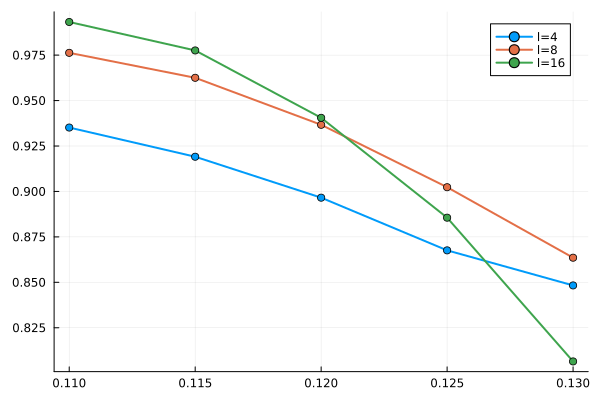

In [30]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)

### 3.3.2 taking care of  priors carefully